# Deep Reinforcement Learning for 2048

In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
from _2048_ import _2048

## Game Setup

In [3]:
game = _2048()

Here we using number **0, 1, 2, 3** to represent the movement of **down, left, up, right**.

State: game.matrix\
Action: [0,1,2,3]\
Reward: game.score\
Win Condition: the player obtain 2048\
Lost Condition: the player in blocked

The approach could consist in representing the state space by an array of size 16 with each entry being an integer in [0,15].

In [5]:
def log2(n):
    if n == 1:
        return 0
    return 1 + log2(n>>1)

def matrix_to_state(matrix):
    state = np.zeros(16)
    x,y = matrix.shape
    for j in range(x):
        for i in range(y):
            if matrix[j][i] == 0:
                state[j*x+i] == 0
            else:
                state[j*x+i] = log2(matrix[j][i])
    return np.array(state)

## Using the Policy Network with Reinforcement Learning

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Frontward Propagation Model

In [8]:
# Design the model

class Frontward_propagation():
    def __init__(self, W1, W2, W3):
        self.h1 = 0
        self.h2 = 0

    def max_0(self, matrix):
        for i in range(len(matrix)):
            if matrix[i] < 0:
                    matrix[i] = 0
        return matrix

    def Frontward(self, state):
        '''
            Setup a network Module for the front propagation
        '''
        state = torch.tensor(state).float()

        self.h1 = F.relu(self.max_0(state @ W1)) 
        self.h2 = F.relu(self.max_0(self.h1 @ W2))
        softmax = nn.Softmax(0)
        self.prob = softmax(self.h2 @ W3)

        return self.prob
    
    def action(self):
        action = random.choices([0,1,2,3], weights= self.prob)[0]
        return action

## Backward Propagation Functions

In [9]:
def action_to_array(action):
    array = np.zeros(4)
    array[action] = 1
    return array

def reward_array(game, n, N_batch, action):
    array = np.zeros(N_batch)
    #array[n] = game.High_value
    array[n] = game.step_score
    return array

In [10]:
def compute_gradient(W1, W2, W3, states, H1, H2, prob, actions, rewards):
    
    V = rewards @ (actions - prob)
    dW3 = H2.T @ V

    dH2 = V @ W3.T
    dW2 = H1.T @ dH2 
    
    dH1 = dH2 @ W2.T
    dW1 = states.T @ dH1
    
    return dW1, dW2, dW3

In [59]:
W1 = torch.FloatTensor(16, 200).uniform_(-0.25, 0.25)
W2 = torch.FloatTensor(200, 100).uniform_(-0.25, 0.25)
W3 = torch.FloatTensor(100, 4).uniform_(-0.25, 0.25)

N_iteration = 1000
N_batch = 100
lr = 1e-6
states = torch.empty((N_batch,16))
H1 = torch.empty((N_batch,200))
H2 = torch.empty((N_batch,100))
prob = torch.empty((N_batch,4))
actions = torch.empty((N_batch,4))
rewards = torch.empty((N_batch,N_batch))

# list to store the performance
High_value_achieved = []

for i in range(N_iteration):
    
    '''
    Game playing and NN training
    '''
    
    # initialization of a new game
    game = _2048()
    n = 0
    while n < N_batch and game.FAIL == False:
        
        # front-propagation for N training examples in one iteration
        s = matrix_to_state(game.matrix)
        m_front = Frontward_propagation(W1, W2, W3)
        p = m_front.Frontward(s)
        a = m_front.action()
        
        # only if the action is feasible, save values for back-propagation
        if game.verif_action(a) == True:
            states[n] = torch.FloatTensor(s)
            H1[n] = m_front.h1
            H2[n] = m_front.h2
            prob[n] = p
            actions[n] = torch.FloatTensor(action_to_array(a))
            rewards[n] = torch.FloatTensor(reward_array(game, n, N_batch, a))

        # if the action is unfeasible, choose a random action
        else:
            a = np.random.randint(0,4)
            
        # execute action
        game.one_step(a)
        n += 1
        
        #if game.FAIL == True:
            #print("FAIL", n, game.nb_de_tours, game.score)
        
    '''
    Back propagation implementation
    '''
    dW1, dW2, dW3 = compute_gradient(W1, W2, W3, states, H1, H2, prob, actions, rewards)

    W1 -= lr * dW1
    W2 -= lr * dW2
    W3 -= lr * dW3
    
    High_value_achieved.append(game.High_value)   

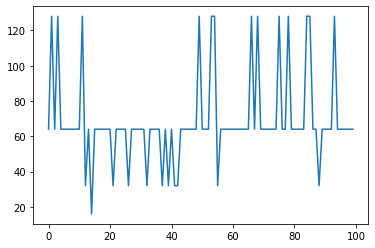

In [58]:
x=np.arange(0,len(High_value_achieved))
plt.plot(x,High_value_achieved)

plt.show()